In [ ]:
"""
CS895_Computational_Imaging_Spring_2025__
|
DNA_DAMAGE_QUANTIFICATION (DDQ)
CS895_CI_ddq_custom_model_training.ipynb
Created on Tue Feb 25 18:23:59 2025
@authors: Rochana Obadage and Kumushini Thennakoon
|
Referenced from: https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.ipynb
"""


# cellpose 3.1

We will first install cellpose 3.1, check the GPU is working, and mount google drive to get your models and images.

## Installation

In [1]:
!pip install numpy==1.26.4

In [2]:
!pip install numpy==1.26.4
!pip uninstall -y cellpose

Found existing installation: cellpose 3.1.1
Uninstalling cellpose-3.1.1:
  Successfully uninstalled cellpose-3.1.1


In [3]:
!pip install "opencv-python-headless<4.3"
!pip install "cellpose==3.1.1"

  Using cached cellpose-3.1.1-py3-none-any.whl.metadata (22 kB)
Using cached cellpose-3.1.1-py3-none-any.whl (225 kB)


`Check CUDA version and that GPU is working in cellpose and import other libraries.`

In [4]:
# !nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

from natsort import natsorted

# import matplotlib.pyplot as plt
# import numpy as np
# from skimage import io


use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

Thu Oct  2 08:35:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.65.06              Driver Version: 580.65.06      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...    Off |   00000000:01:00.0 Off |                  N/A |
|  0%   35C    P8              6W /  285W |      77MiB /  16376MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Update paths to match your actual folder structure
train_files = natsorted(glob('train/*.tif'))
train_seg = natsorted(glob('train/*_seg.npy'))

test_files = natsorted(glob('test/*.tif'))
test_seg = natsorted(glob('test/*_seg.npy'))

# Print the files found to verify paths
print("Training files found:")
for f in train_files:
    print(f"  {f}")
    
print("\nTraining segmentation files found:")
for f in train_seg:
    print(f"  {f}")
    
print("\nTest files found:")
for f in test_files:
    print(f"  {f}")
    
print("\nTest segmentation files found:")
for f in test_seg:
    print(f"  {f}")

Training files found:
  train/4Gy_53BP1_1Hr.tif
  train/4Gy_53BP1_4Hr.tif
  train/4Gy_gH2AX_1Hr.tif
  train/4Gy_gH2AX_4Hr.tif
  train/8Gy_53BP1_1Hr.tif
  train/8Gy_53BP1_4Hr.tif
  train/8Gy_gH2AX_1Hr.tif

Training segmentation files found:
  train/4Gy_53BP1_1Hr_seg.npy
  train/4Gy_53BP1_4Hr_seg.npy
  train/4Gy_gH2AX_1Hr_seg.npy
  train/4Gy_gH2AX_4Hr_seg.npy
  train/8Gy_53BP1_1Hr_seg.npy
  train/8Gy_53BP1_4Hr_seg.npy
  train/8Gy_gH2AX_1Hr_seg.npy

Test files found:
  test/4Gy_53BP1_8Hr.tif
  test/4Gy_gH2AX_8Hr.tif
  test/8Gy_53BP1_8Hr.tif
  test/8Gy_gH2AX_8Hr.tif

Test segmentation files found:
  test/4Gy_53BP1_8Hr_seg.npy
  test/4Gy_gH2AX_8Hr_seg.npy
  test/8Gy_53BP1_8Hr_seg.npy
  test/8Gy_gH2AX_8Hr_seg.npy


`what the training images look like + their labels`

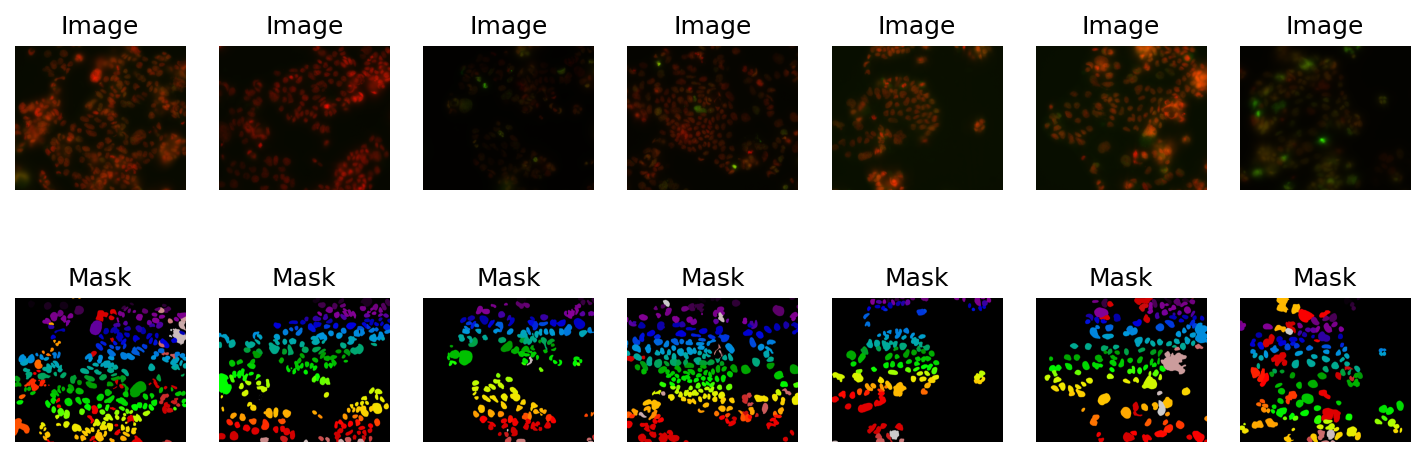

In [6]:
# %matplotlib inline
plt.figure(figsize=(12, 4), dpi=150)

for k, f in enumerate(train_files):
    # Load image
    img = io.imread(f)

    # Normalize image if needed
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # scale to [0, 1]

    # Plot image
    plt.subplot(2, len(train_files), k + 1)
    img = np.vstack((img, np.zeros_like(img)[:1]))  # Optional: remove if not needed
    img = img.transpose(1, 2, 0) if img.ndim == 3 else img
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")

    # Load and plot mask
    plt.subplot(2, len(train_files), len(train_files) + k + 1)
    seg_path = os.path.splitext(f)[0] + '_seg.npy'
    seg = np.load(seg_path, allow_pickle=True).item()
    masks = seg['masks'].squeeze()
    plt.imshow(masks, cmap='nipy_spectral')  # color-coded mask
    plt.axis('off')
    plt.title("Mask")


# Train model on manual annotations

## Training parameters

<font size = 2> **Paths for training, predictions and results**


<font size = 2>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images).

<font size = 2>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 2>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 2>**Training parameters**

<font size = 2>**`number_of_epochs`:** Input how many epochs the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [7]:
train_dir = "train" 
test_dir = "test" 

#Define where the patch file will be saved
base = "cellpose"

# model name and path
from cellpose import models
initial_model = "nuclei" # ["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "ddq_model_1"

# other parameters for training.
n_epochs =  100
Channel_to_use_for_training = "Red" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:
Second_training_channel= "None" #@param ["None", "Blue", "Green", "Red"]

# Advanced Parameters
Use_Default_Advanced_Parameters = True
learning_rate = 0.1 
weight_decay = 0.0001 

if (Use_Default_Advanced_Parameters):
  print("Default advanced parameters enabled")
  learning_rate = 0.1
  weight_decay = 0.0001

#here we check that no model with the same name already exist, if so delete
model_path = 'custom_models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")

if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


Here's what the command to train would be on the command line -- make sure if you run this locally to correct the paths for your local computer.

In [15]:
run_str = f'python -m cellpose --use_gpu --verbose --train --dir {train_dir} --pretrained_model {initial_model} --chan {chan} --chan2 {chan2} --n_epochs {n_epochs} --learning_rate {learning_rate} --weight_decay {weight_decay}'
if test_dir is not None:
    run_str += f' --test_dir {test_dir}'
run_str += ' --mask_filter _seg.npy' # if you want to use _seg.npy files for training
print(run_str)

python -m cellpose --use_gpu --verbose --train --dir dataset/train --pretrained_model nuclei --chan 1 --chan2 0 --n_epochs 100 --learning_rate 0.1 --weight_decay 0.0001 --test_dir dataset/test --mask_filter _seg.npy


## Train new model

Using settings from form above, train model in notebook.

In [8]:
from cellpose import train

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path, train_losses, test_losses = train.train_seg(model.net, train_data=train_data,
                              train_labels=train_labels,
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels,
                              save_path=model_path,
                              n_epochs=n_epochs,
                              learning_rate=learning_rate,
                              weight_decay=weight_decay,
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2025-10-02 08:36:21,917 [INFO] WRITING LOG OUTPUT TO /home/cse/.cellpose/run.log
2025-10-02 08:36:21,918 [INFO] 
cellpose version: 	3.1.1 
platform:       	linux 
python version: 	3.12.3 
torch version:  	2.8.0+cu128
2025-10-02 08:36:21,920 [INFO] >> nuclei << model set to be used
2025-10-02 08:36:21,931 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:36:21,932 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:36:21,965 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-02 08:36:22,009 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-02 08:36:22,010 [INFO] not all flows are present, running flow generation for all images
2025-10-02 08:36:22,136 [INFO] 7 / 7 images in train folder have labels
2025-10-02 08:36:22,137 [INFO] not all flows are present, running flow generation for all images
2025-10-02 08:36:22,522 [INFO] 4 / 4 images in test folder have labels
2025-10-02 08:36:22,522 [INFO] computing flows for 

100%|██████████| 7/7 [00:12<00:00,  1.79s/it]

2025-10-02 08:36:35,076 [INFO] computing flows for labels



100%|██████████| 4/4 [00:01<00:00,  3.55it/s]

2025-10-02 08:36:36,216 [INFO] >>> computing diameters



100%|██████████| 4/4 [00:00<00:00, 89.12it/s]

2025-10-02 08:36:36,346 [INFO] >>> using channels [1, 0]
2025-10-02 08:36:36,346 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': True, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}


2025-10-02 08:36:37,232 [INFO] >>> n_epochs=100, n_train=7, n_test=4
2025-10-02 08:36:37,232 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2025-10-02 08:36:37,856 [INFO] >>> saving model to custom_models/models/ddq_model_1
2025-10-02 08:36:38,742 [INFO] 0, train_loss=0.3903, test_loss=1.4235, LR=0.000000, time 0.89s
2025-10-02 08:36:40,197 [INFO] 5, train_loss=0.4473, test_loss=1.5787, LR=0.055556, time 2.34s
2025-10-02 08:36:41,723 [INFO] 10, train_loss=0.3448, test_loss=2.0543, LR=0.100000, time 3.87s
2025-10-02 08:36:44,633 [INFO] 20, train_loss=0.3033, test_loss=1.7906, LR=0.100000, time 6.78s
2025-10-02 08:36:47,735 [INFO] 30, train_loss=0.2674, test_loss=1.8532, LR=0.100000, time 9.88s
2025-10-02 08:36:50,753 [INFO] 40, train_loss=0.2521, test_loss=1.7924, LR=0.100000, time 12.90s
2025-10-02 08:36:53,689 [INFO] 50, train_loss=0.2394, test_loss=1.6596, LR=0.100000, time 15.83s
2025-10-02 08:36:56,767 [INFO] 60, train_loss=0.2231, test_loss=1.6895, LR=

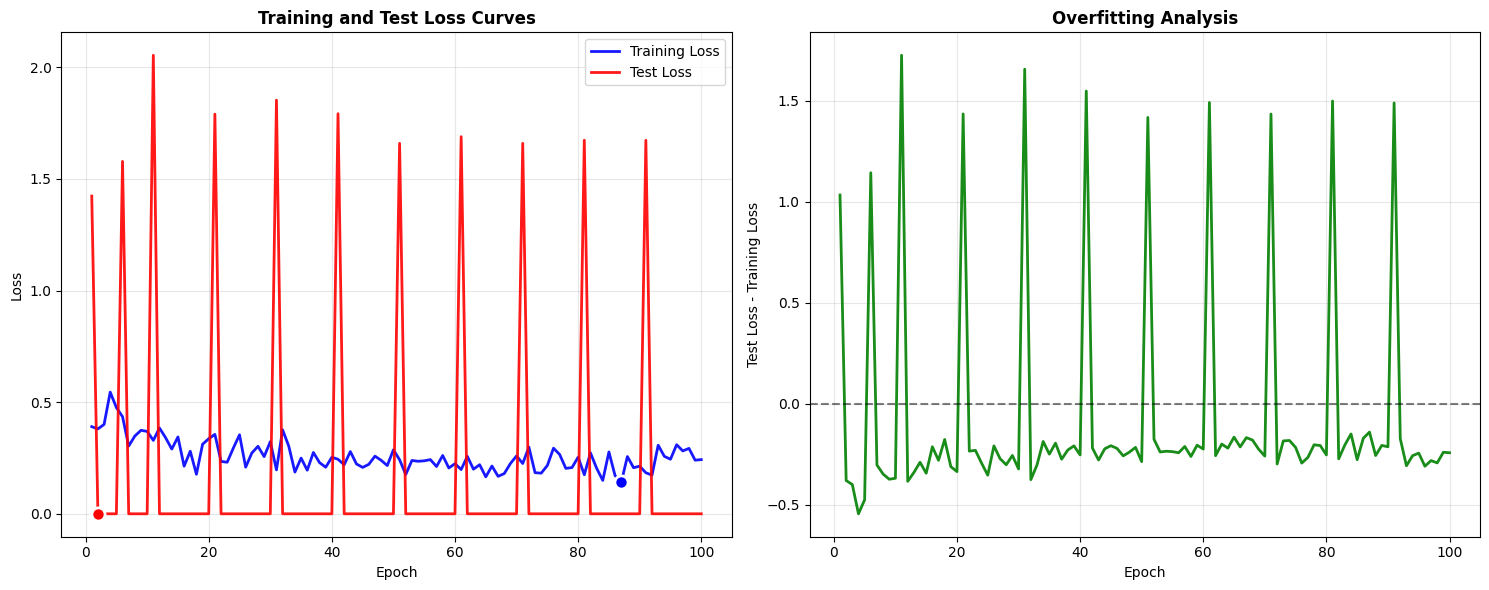

📊 TRAINING PERFORMANCE ANALYSIS
🔵 TRAINING LOSS STATISTICS:
   Training epochs:        100
   Final training loss:    0.2428
   Best training loss:     0.1405 (epoch 87)
   Training improvement:   37.8%

🔴 TEST LOSS STATISTICS:
   Test epochs:            100
   Final test loss:        0.0000
   Best test loss:         0.0000 (epoch 2)
   Test improvement:       100.0%

🔍 OVERFITTING ANALYSIS:
   Final loss gap:         0.2428
   Gap percentage:         2428139895.2%
   📊 Status:              ❌ Significant overfitting
   Best epoch (test):      2


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- normalize inputs to numpy arrays and clean up ---
train_losses = np.asarray(train_losses, dtype=float)
test_losses = None if 'test_losses' not in globals() or test_losses is None else np.asarray(test_losses, dtype=float)

# keep only finite values
train_losses = train_losses[np.isfinite(train_losses)]
if test_losses is not None:
    test_losses = test_losses[np.isfinite(test_losses)]

# validity checks
has_valid_test_loss = (
    test_losses is not None
    and test_losses.size > 0
    and not np.allclose(test_losses, 0.0)
)

# ---- plotting ----
if has_valid_test_loss:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Left: losses
    train_epochs = np.arange(1, train_losses.size + 1)
    test_epochs  = np.arange(1, test_losses.size  + 1)

    ax1.plot(train_epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.9)
    ax1.plot(test_epochs,  test_losses,  'r-', linewidth=2, label='Test Loss',     alpha=0.9)

    # highlight minima (guard for empty after cleaning)
    if train_losses.size:
        min_train_idx = int(np.argmin(train_losses))
        ax1.scatter(min_train_idx + 1, train_losses[min_train_idx],
                    color='blue', s=90, marker='o', edgecolor='white', linewidth=2, zorder=5)
    if test_losses.size:
        min_test_idx = int(np.argmin(test_losses))
        ax1.scatter(min_test_idx + 1, test_losses[min_test_idx],
                    color='red', s=90, marker='o', edgecolor='white', linewidth=2, zorder=5)

    ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
    ax1.set_title('Training and Test Loss Curves', fontweight='bold')
    ax1.legend(); ax1.grid(alpha=0.3)

    # Right: overfitting gap (aligned length)
    min_len = int(min(train_losses.size, test_losses.size))
    if min_len > 0:
        loss_gap = test_losses[:min_len] - train_losses[:min_len]
        ax2.plot(np.arange(1, min_len + 1), loss_gap, 'g-', linewidth=2, alpha=0.9)
    ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
    ax2.set_xlabel('Epoch'); ax2.set_ylabel('Test Loss - Training Loss')
    ax2.set_title('Overfitting Analysis', fontweight='bold')
    ax2.grid(alpha=0.3)

    plt.tight_layout(); plt.show()

else:
    # Only training loss
    if train_losses.size:
        plt.figure(figsize=(10, 6))
        epochs = np.arange(1, train_losses.size + 1)
        plt.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', alpha=0.9)
        min_train_idx = int(np.argmin(train_losses))
        plt.scatter(min_train_idx + 1, train_losses[min_train_idx],
                    color='blue', s=90, marker='o', edgecolor='white', linewidth=2, zorder=5)
        plt.xlabel('Epoch'); plt.ylabel('Loss')
        plt.title('Training Loss Curve (No Test Data Available)', fontweight='bold')
        plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()

# ---- text stats ----
print(" TRAINING PERFORMANCE ANALYSIS")
print("=" * 60)
print(" TRAINING LOSS STATISTICS:")
print(f"   Training epochs:        {train_losses.size}")
if train_losses.size:
    print(f"   Final training loss:    {train_losses[-1]:.4f}")
    print(f"   Best training loss:     {train_losses.min():.4f} (epoch {int(np.argmin(train_losses))+1})")
    initial_train, final_train = train_losses[0], train_losses[-1]
    if initial_train != 0:
        train_improvement = ((initial_train - final_train) / initial_train) * 100
        print(f"   Training improvement:   {train_improvement:.1f}%")

if has_valid_test_loss and test_losses.size:
    print(f"\n TEST LOSS STATISTICS:")
    print(f"   Test epochs:            {test_losses.size}")
    print(f"   Final test loss:        {test_losses[-1]:.4f}")
    print(f"   Best test loss:         {test_losses.min():.4f} (epoch {int(np.argmin(test_losses))+1})")
    initial_test, final_test = test_losses[0], test_losses[-1]
    if initial_test != 0:
        test_improvement = ((initial_test - final_test) / initial_test) * 100
        print(f"   Test improvement:       {test_improvement:.1f}%")

    print(f"\n🔍 OVERFITTING ANALYSIS:")
    final_gap = float(abs(train_losses[-1] - test_losses[-1]))
    denom = float(abs(test_losses[-1])) if test_losses[-1] != 0 else 1e-8
    gap_percentage = (final_gap / denom) * 100.0
    print(f"   Final loss gap:         {final_gap:.4f}")
    print(f"   Gap percentage:         {gap_percentage:.1f}%")
    status = ("✅ Good generalization" if gap_percentage < 10
              else "⚠️  Mild overfitting" if gap_percentage < 25
              else "❌ Significant overfitting")
    print(f"   📊 Status:              {status}")
    print(f"   Best epoch (test):      {int(np.argmin(test_losses))+1}")
else:
    print(f"\n⚠️  TEST LOSS: Not available")
    print("   Reason: No valid test data/loss provided")
    print("   Recommendation: Include test data for better monitoring")
print("=" * 60)


## Evaluate on test data (optional)

If you have test data, check performance

In [13]:
saved_model_path = "custom_models/models/ddq_model_1"
evaluation_model = models.CellposeModel(gpu=True, pretrained_model=saved_model_path)

print(f"Saved custom model loaded from: {saved_model_path}")
print(f"Model diameter: {evaluation_model.diam_labels}")

# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

print(f"Test data: {len(test_data)} images loaded")

print("Testing saved custom model...")
masks = evaluation_model.eval(test_data, channels=[chan, chan2], diameter=None)[0]
ap = metrics.average_precision(test_labels, masks)[0]
print(f"   Saved model AP@0.5: {ap[:,0].mean():.4f}")

print(f"   Saved model:       {ap[:,0].mean():.4f}")

print(f">>> CORRECTED average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}")

# Individual image performance breakdown
print(f"\n📋 INDIVIDUAL IMAGE PERFORMANCE:")
for i in range(len(test_labels)):
    individual_ap = metrics.average_precision([test_labels[i]], [masks[i]])[0]
    gt_cells = len(np.unique(test_labels[i])) - 1
    pred_cells = len(np.unique(masks[i])) - 1
    print(f"  Image {i+1}: AP@0.5 = {individual_ap[0,0]:.3f}, GT={gt_cells}, Pred={pred_cells}")

print("=" * 70)

2025-10-02 08:48:56,357 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:48:56,357 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:48:56,357 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:48:56,381 [INFO] >>>> loading model custom_models/models/ddq_model_1
2025-10-02 08:48:56,381 [INFO] >>>> loading model custom_models/models/ddq_model_1


2025-10-02 08:48:56,405 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-02 08:48:56,405 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
Saved custom model loaded from: custom_models/models/ddq_model_1
Model diameter: 85.00520324707031
2025-10-02 08:48:56,406 [INFO] not all flows are present, running flow generation for all images
2025-10-02 08:48:56,405 [INFO] >>>> model diam_labels =  85.005 (mean diameter of training ROIs)
Saved custom model loaded from: custom_models/models/ddq_model_1
Model diameter: 85.00520324707031
2025-10-02 08:48:56,406 [INFO] not all flows are present, running flow generation for all images
2025-10-02 08:48:56,532 [INFO] 4 / 4 images in test folder have labels
Test data: 4 images loaded
Testing saved custom model...
2025-10-02 08:48:56,535 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-10-02 08:48:56,532 [INFO] 4 / 4 images in test folder have labels
Test data: 4 images loaded
Testing saved 

plot masks

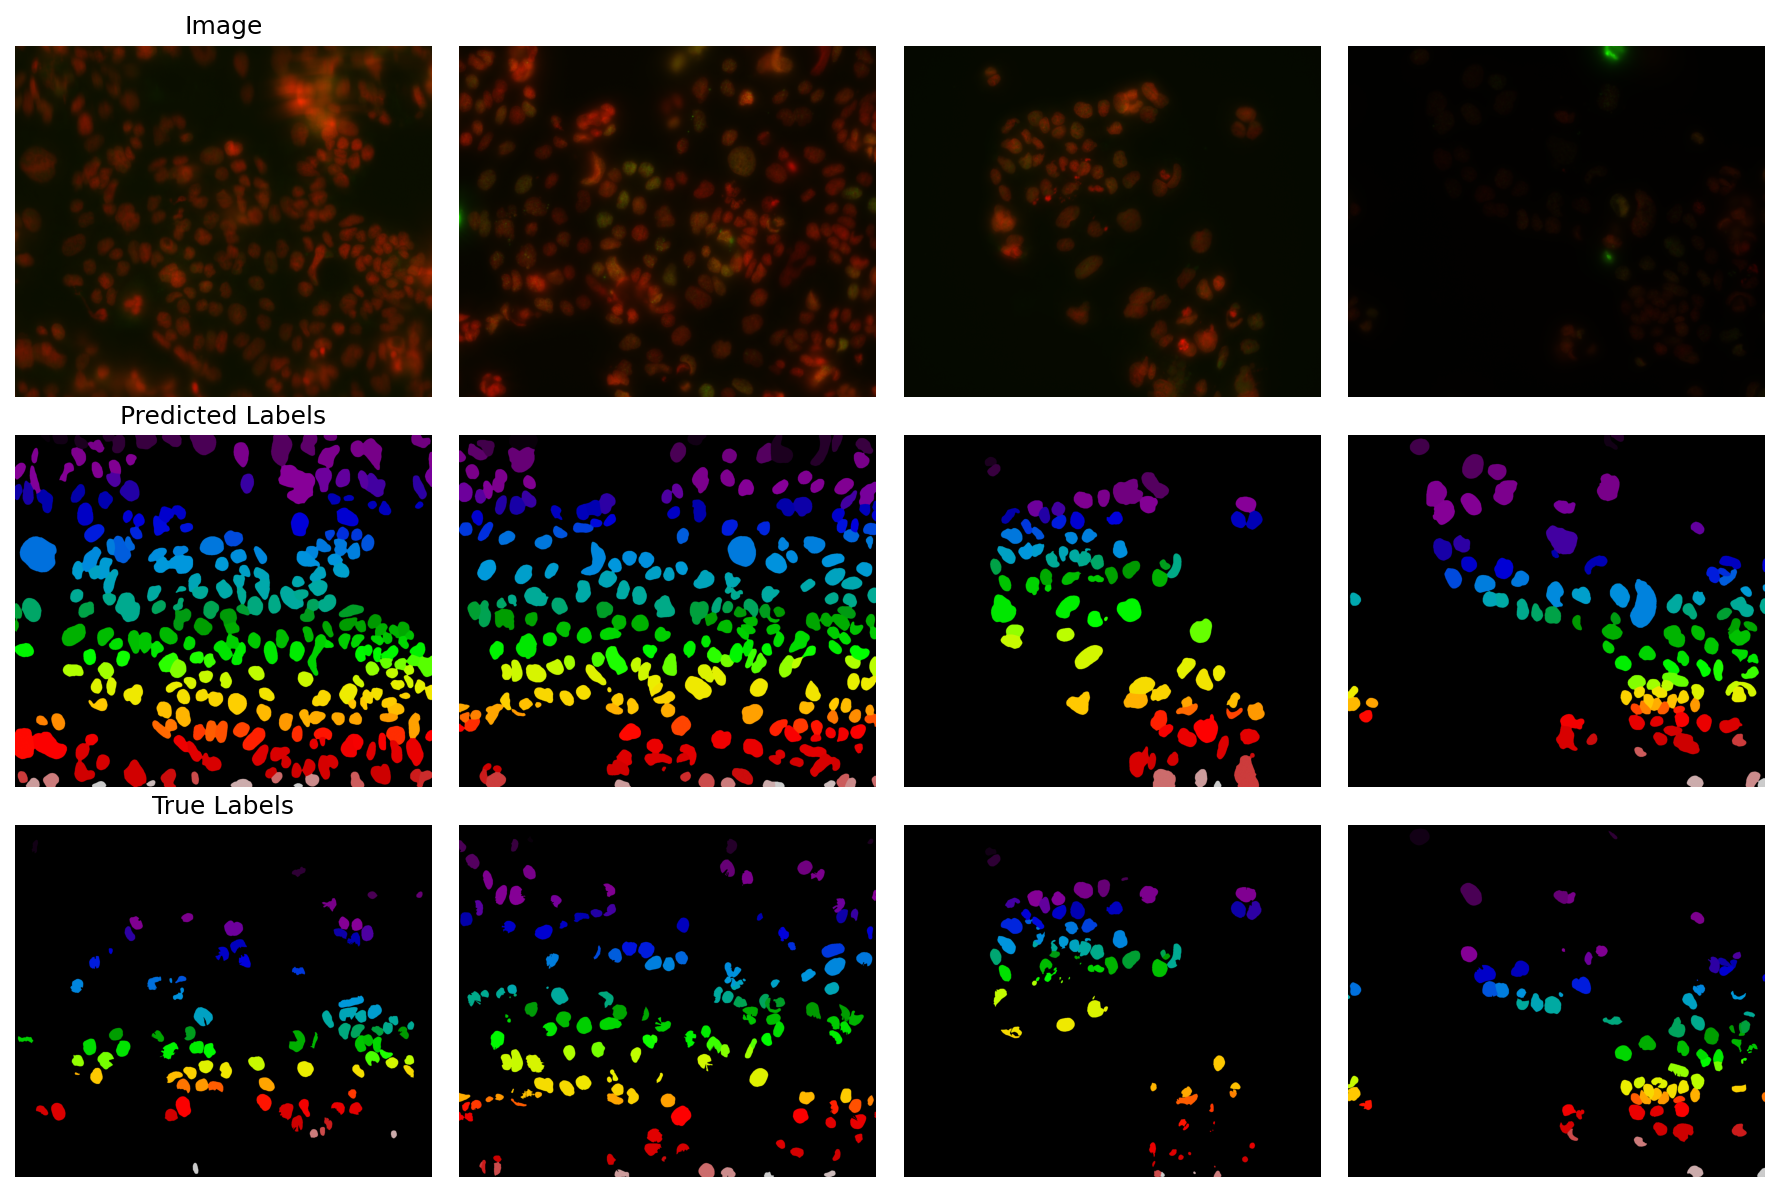

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 8), dpi=150)

for k, im in enumerate(test_data):
    # Copy image and normalize if needed
    img = im.copy()
    if img.dtype != np.uint8:
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1  # Normalize to [0,1]

    # Optional padding (can remove if unnecessary)
    img = np.vstack((img, np.zeros_like(img)[:1]))

    # Transpose if in (C, H, W) format
    if img.ndim == 3 and img.shape[0] <= 4:
        img = img.transpose(1, 2, 0)

    # Plot original image
    plt.subplot(3, len(test_data), k + 1)
    plt.imshow(img)
    plt.axis('off')
    if k == 0:
        plt.title('Image')

    # Plot predicted mask
    plt.subplot(3, len(test_data), len(test_data) + k + 1)
    plt.imshow(masks[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('Predicted Labels')

    # Plot ground truth
    plt.subplot(3, len(test_data), 2 * len(test_data) + k + 1)
    plt.imshow(test_labels[k], cmap='nipy_spectral')
    plt.axis('off')
    if k == 0:
        plt.title('True Labels')

plt.tight_layout()
plt.show()


# Use custom model to segment images

In [15]:
model_path = "custom_models/models/ddq_model_1/models/ddq_model_1"
image_dir = "test" 

# Channel Parameters:

Channel_to_use_for_segmentation = "Red" # ["Grayscale", "Blue", "Green", "Red"]
Second_segmentation_channel= "None" # ["None", "Blue", "Green", "Red"]

# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1

if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

# Segmentation parameters:
# diameter of cells (set to zero to use diameter from training set):
diameter =  0 # {type:"number"}

# threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 # {type:"slider", min:0.0, max:3.0, step:0.1}

# threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 # {type:"slider", min:-6, max:6, step:1}

In [25]:
run_str = f'python -m cellpose --use_gpu --verbose --dir {image_dir} --pretrained_model {model_path} --chan {chan} --chan2 {chan2} --diameter {diameter} --flow_threshold {flow_threshold} --cellprob_threshold {cellprob_threshold}'
print(run_str)

python -m cellpose --use_gpu --verbose --dir dataset/create_new_labels --pretrained_model custom_models/models/ddq_model_1 --chan 1 --chan2 0 --diameter 0 --flow_threshold 0.4 --cellprob_threshold 0


## run custom model

In [16]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(image_dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True,
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images,
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['test/4Gy_53BP1_8Hr.tif', 'test/4Gy_gH2AX_8Hr.tif', 'test/8Gy_53BP1_8Hr.tif', 'test/8Gy_gH2AX_8Hr.tif']
2025-10-02 08:52:06,509 [WARNING] pretrained_model path does not exist, using default model
2025-10-02 08:52:06,518 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:52:06,518 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:52:06,519 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:52:06,519 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:52:06,543 [INFO] >>>> loading model /home/cse/.cellpose/models/cyto3
2025-10-02 08:52:06,543 [INFO] >>>> loading model /home/cse/.cellpose/models/cyto3
2025-10-02 08:52:06,582 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-10-02 08:52:06,583 [INFO] 0%|          | 0/4 [00:00<?, ?it/s]
2025-10-02 08:52:06,582 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2025-10-02 08:52:12,487 [INFO] 100%|##########| 4/4 [00:05<00:00,  1.48s/it]


## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [17]:
from cellpose import io

io.masks_flows_to_seg(images,
                      masks,
                      flows,
                      files,
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)),
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [18]:
io.save_masks(images,
              masks,
              flows,
              files,
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )

In [19]:
files[3]

'test/8Gy_gH2AX_8Hr.tif'

(-0.5, 3599.5, 899.5, -0.5)

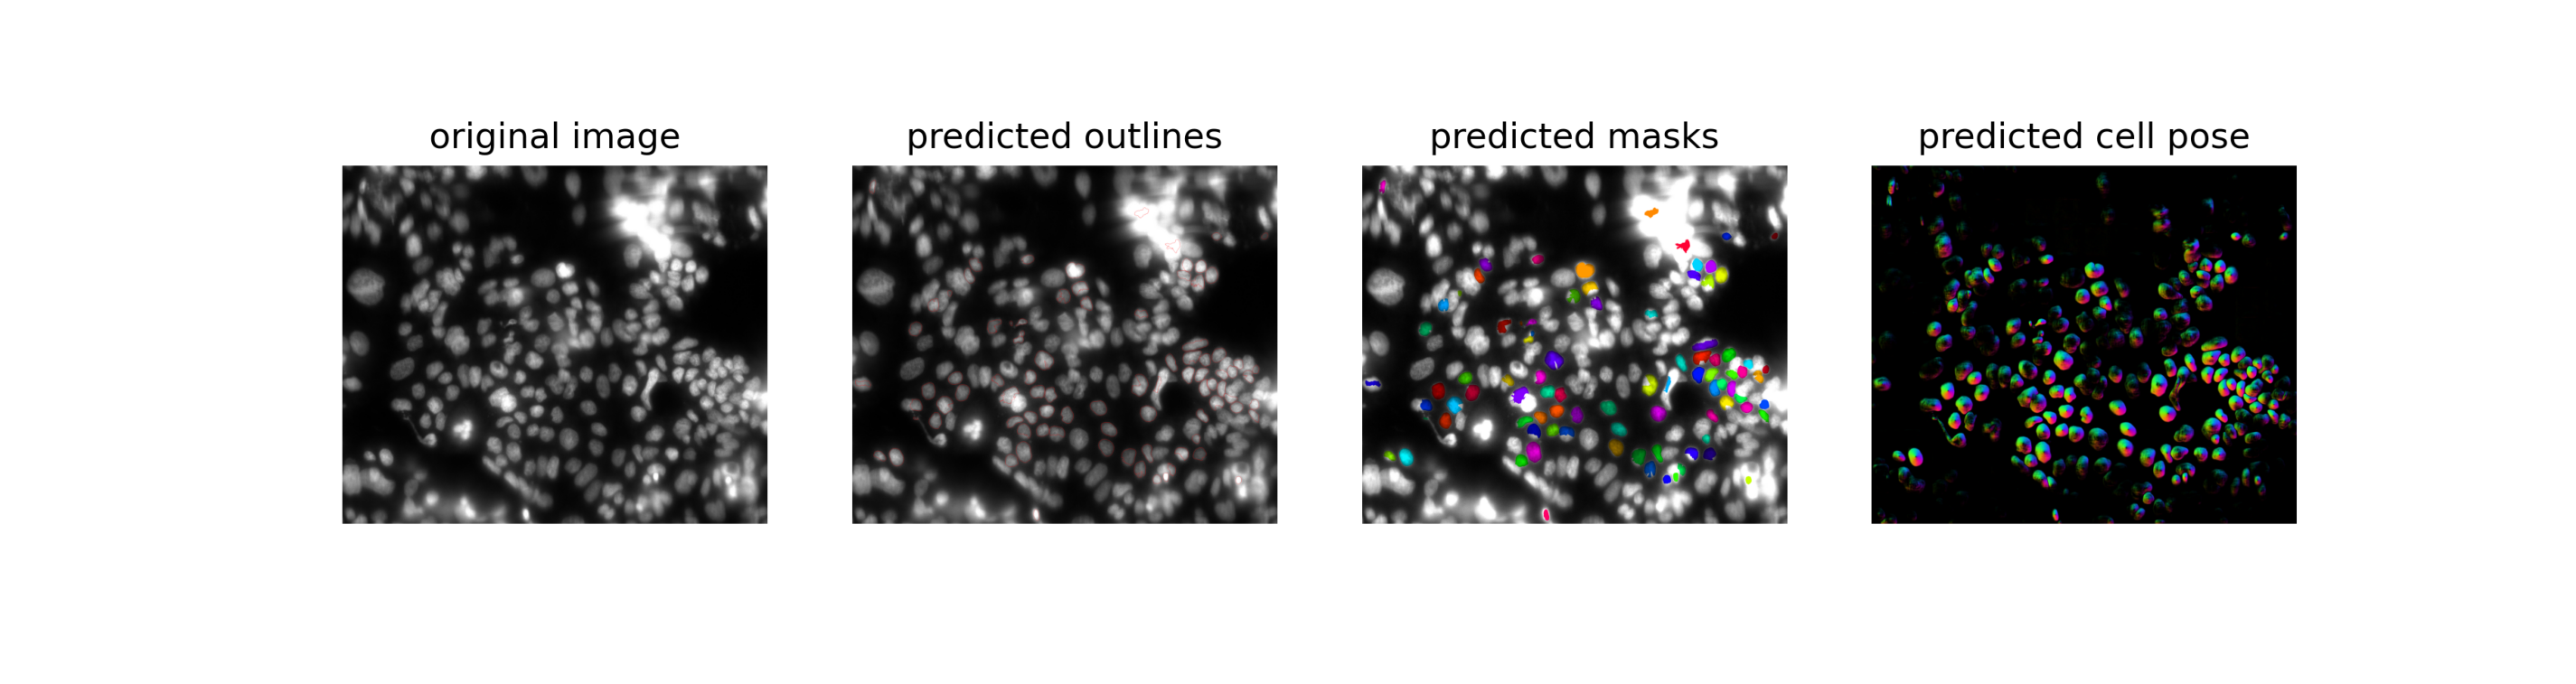

In [20]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output_cp_masks.png'))
plt.axis('off')

In [21]:
# Load test image
test_img_path = 'test/4Gy_53BP1_8Hr.tif'
test_image = io.imread(test_img_path)

print(f"Test image: {test_img_path}")
print(f"Image shape: {test_image.shape}")

# 1. Run original pre-trained nuclei model with CORRECTED parameters
print("\n=== Running Original Nuclei Model (CORRECTED) ===")
original_model = models.CellposeModel(gpu=True, model_type='nuclei')

# Fix the main issues: diameter mismatch and optimize parameters for DDQ images
original_masks, original_flows, original_styles = original_model.eval([test_image],
                                                                     channels=[chan, chan2],  # Keep same channels as custom model
                                                                     diameter=85.0,  # Use diameter matching your cell size (not default 17)
                                                                     flow_threshold=0.4,  # Keep same as custom model
                                                                     cellprob_threshold=0)  # Keep same as custom model

print(f"Original model - Cells detected: {len(np.unique(original_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=85, channels=[{chan},{chan2}], flow_thresh=0.4, cellprob_thresh=0")

# 2. Run your custom trained model  
print("\n=== Running Custom Trained Model ===")
custom_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1/models/ddq_model_1")

custom_masks, custom_flows, custom_styles = custom_model.eval([test_image],
                                                              channels=[chan, chan2],
                                                              diameter=None,  # Use model's trained diameter (85.0)
                                                              flow_threshold=0.4,
                                                              cellprob_threshold=0)

print(f"Custom model - Cells detected: {len(np.unique(custom_masks[0])) - 1}")
print(f"  └─ Parameters: diameter=model_default({custom_model.diam_labels:.1f}), channels=[{chan},{chan2}]")

# Store results for visualization
original_result = original_masks[0]
custom_result = custom_masks[0]

# Performance comparison
print(f"\n=== CORRECTED COMPARISON ===")
original_count = len(np.unique(original_result)) - 1
custom_count = len(np.unique(custom_result)) - 1
difference = custom_count - original_count

print(f"Original nuclei model (corrected): {original_count} cells")
print(f"Custom DDQ model:                   {custom_count} cells")
print(f"Difference:                        {difference:+d} cells")

if abs(difference) <= 20:  # Close performance
    print("✅ Both models perform similarly with corrected parameters!")
elif custom_count > original_count:
    print("🎯 Custom model still detects more cells (better for DDQ)")
else:
    print("⚠️  Original model detects more (might be over-segmenting)")

Test image: test/4Gy_53BP1_8Hr.tif
Image shape: (2, 2160, 2560)

=== Running Original Nuclei Model (CORRECTED) ===
2025-10-02 08:52:47,689 [INFO] >> nuclei << model set to be used
2025-10-02 08:52:47,698 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:52:47,698 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:52:47,698 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:52:47,698 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:52:47,722 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-02 08:52:47,722 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-02 08:52:47,746 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-02 08:52:47,746 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
Original model - Cells detected: 250
  └─ Parameters: diameter=85, channels=[1,0], flow_thresh=0.4, cellprob_thresh=0

=== Running Custom Trained Model ===
2025

# Model Comparison Visualization

Compare the performance of trained model vs original Cellpose vs ground truth with nuclei counts for each test image.

In [22]:
# Comprehensive 3-way model comparison for all test images
import numpy as np
import os

print("🔬 COMPREHENSIVE MODEL COMPARISON FOR ALL TEST IMAGES")
print("=" * 80)

# Get all test images (exclude _cp_masks.tif files)
all_tif_files = natsorted(glob('test/*.tif'))
test_images_paths = [f for f in all_tif_files if not f.endswith('_cp_masks.tif')]
print(f"Found {len(test_images_paths)} test images to process (excluding {len(all_tif_files) - len(test_images_paths)} _cp_masks.tif files)")

# Initialize models
print("\n🔄 Initializing models...")
original_model = models.CellposeModel(gpu=True, model_type='nuclei')
custom_model = models.CellposeModel(gpu=True, pretrained_model="custom_models/models/ddq_model_1/models/ddq_model_1")

# Process each test image
results_summary = []

for idx, test_img_path in enumerate(test_images_paths):
    print(f"\n📊 Processing {idx+1}/{len(test_images_paths)}: {os.path.basename(test_img_path)}")
    
    # Load test image
    test_image = io.imread(test_img_path)
    img_basename = os.path.splitext(os.path.basename(test_img_path))[0]
    
    # Load ground truth (correct format: {image_name}_seg.npy)
    ground_truth_path = f'test/{img_basename}_seg.npy'
    if os.path.exists(ground_truth_path):
        gt_data = np.load(ground_truth_path, allow_pickle=True).item()
        ground_truth_masks = gt_data['masks']
        gt_count = len(np.unique(ground_truth_masks)) - 1
        print(f"   ✅ Ground truth loaded: {gt_count} cells")
    else:
        print(f"   ❌ Ground truth not found: {ground_truth_path}")
        # Check what files actually exist
        available_files = [f for f in os.listdir('test') if f.endswith('_seg.npy')]
        print(f"   Available _seg.npy files: {available_files}")
        continue
    
    # Run original Cellpose model
    print("   🔄 Running original Cellpose model...")
    original_masks, _, _ = original_model.eval([test_image],
                                              channels=[chan, chan2],
                                              diameter=85.0,
                                              flow_threshold=0.4,
                                              cellprob_threshold=0)
    original_result = original_masks[0]
    original_count = len(np.unique(original_result)) - 1
    
    # Run custom trained model
    print("   🎯 Running custom trained model...")
    custom_masks, _, _ = custom_model.eval([test_image],
                                          channels=[chan, chan2],
                                          diameter=None,
                                          flow_threshold=0.4,
                                          cellprob_threshold=0)
    custom_result = custom_masks[0]
    custom_count = len(np.unique(custom_result)) - 1
    
    # Calculate accuracy for this image
    original_accuracy = 100 - abs(original_count - gt_count) / gt_count * 100 if gt_count > 0 else 0
    custom_accuracy = 100 - abs(custom_count - gt_count) / gt_count * 100 if gt_count > 0 else 0
    
    # Determine winner for this image
    if custom_accuracy > original_accuracy:
        winner = "🎯 Custom Model"
    elif original_accuracy > custom_accuracy:
        winner = "🔵 Original Model"
    else:
        winner = "🤝 Tie"
    
    # Store results
    result = {
        'image': img_basename,
        'ground_truth': gt_count,
        'original_cellpose': original_count,
        'custom_trained': custom_count,
        'original_vs_gt': original_count - gt_count,
        'custom_vs_gt': custom_count - gt_count,
        'custom_vs_original': custom_count - original_count,
        'original_accuracy': original_accuracy,
        'custom_accuracy': custom_accuracy
    }
    results_summary.append(result)
    
    print(f"   📈 Results: GT={gt_count}, Original={original_count} ({original_accuracy:.1f}%), Custom={custom_count} ({custom_accuracy:.1f}%)")
    print(f"   🏆 Winner: {winner}")

# Overall summary
print("\n" + "=" * 80)
print("📊 OVERALL PERFORMANCE SUMMARY")
print("=" * 80)

# Calculate overall statistics
total_gt = sum(r['ground_truth'] for r in results_summary)
total_orig = sum(r['original_cellpose'] for r in results_summary)
total_custom = sum(r['custom_trained'] for r in results_summary)

print(f"Images processed: {len(results_summary)}")
print(f"Total nuclei counts:")
print(f"  Ground Truth:     {total_gt:4d}")
print(f"  Original Cellpose: {total_orig:4d} ({total_orig - total_gt:+4d})")
print(f"  Custom Trained:   {total_custom:4d} ({total_custom - total_gt:+4d})")

# Overall accuracy
overall_orig_accuracy = 100 - abs(total_orig - total_gt) / total_gt * 100
overall_custom_accuracy = 100 - abs(total_custom - total_gt) / total_gt * 100

print(f"\nOverall Accuracy vs Ground Truth:")
print(f"  Original Cellpose: {overall_orig_accuracy:.1f}%")
print(f"  Custom Trained:   {overall_custom_accuracy:.1f}%")
print(f"  Improvement:      {overall_custom_accuracy - overall_orig_accuracy:+.1f}%")

# Count wins
custom_wins = sum(1 for r in results_summary if r['custom_accuracy'] > r['original_accuracy'])
original_wins = sum(1 for r in results_summary if r['original_accuracy'] > r['custom_accuracy'])
ties = len(results_summary) - custom_wins - original_wins

print(f"\nImage-by-Image Performance:")
print(f"  🎯 Custom Model wins:    {custom_wins}/{len(results_summary)} images")
print(f"  🔵 Original Model wins:  {original_wins}/{len(results_summary)} images")
print(f"  🤝 Ties:                 {ties}/{len(results_summary)} images")

# Detailed results table
print(f"\n📋 DETAILED RESULTS:")
print(f"{'Image':<20} {'GT':>4} {'Orig':>4} {'Custom':>6} {'Orig vs GT':>10} {'Custom vs GT':>12} {'Accuracy Orig':>13} {'Accuracy Custom':>15}")
print("-" * 100)

for r in results_summary:
    print(f"{r['image']:<20} {r['ground_truth']:>4} {r['original_cellpose']:>4} {r['custom_trained']:>6} "
          f"{r['original_vs_gt']:>+10} {r['custom_vs_gt']:>+12} {r['original_accuracy']:>12.1f}% {r['custom_accuracy']:>14.1f}%")

print("=" * 80)

🔬 COMPREHENSIVE MODEL COMPARISON FOR ALL TEST IMAGES
Found 4 test images to process (excluding 4 _cp_masks.tif files)

🔄 Initializing models...
2025-10-02 08:54:26,085 [INFO] >> nuclei << model set to be used
2025-10-02 08:54:26,095 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:54:26,095 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:54:26,095 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:54:26,095 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:54:26,121 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-02 08:54:26,121 [INFO] >>>> loading model /home/cse/.cellpose/models/nucleitorch_0
2025-10-02 08:54:26,145 [INFO] >>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
2025-10-02 08:54:26,146 [WARNING] pretrained_model path does not exist, using default model
2025-10-02 08:54:26,146 [INFO] ** TORCH CUDA version installed and working. **
2025-10-02 08:54:26,146 [INFO] >>>> using GPU (CUDA)
2025-10-02 08:

🎨 DISPLAYING AND SAVING ALL INSTANCE MASKS WITH RANDOMIZED COLORS
Found 4 mask files to display and save:
  📁 4Gy_53BP1_8Hr_cp_masks.tif
  📁 4Gy_gH2AX_8Hr_cp_masks.tif
  📁 8Gy_53BP1_8Hr_cp_masks.tif
  📁 8Gy_gH2AX_8Hr_cp_masks.tif


🖼️  Image 1/4: 4Gy_53BP1_8Hr
--------------------------------------------------
📂 Loaded: 4Gy_53BP1_8Hr_cp_masks.tif
📐 Mask shape: (2160, 2560)
🔢 Nuclei detected: 269
📊 Value range: 0 - 269


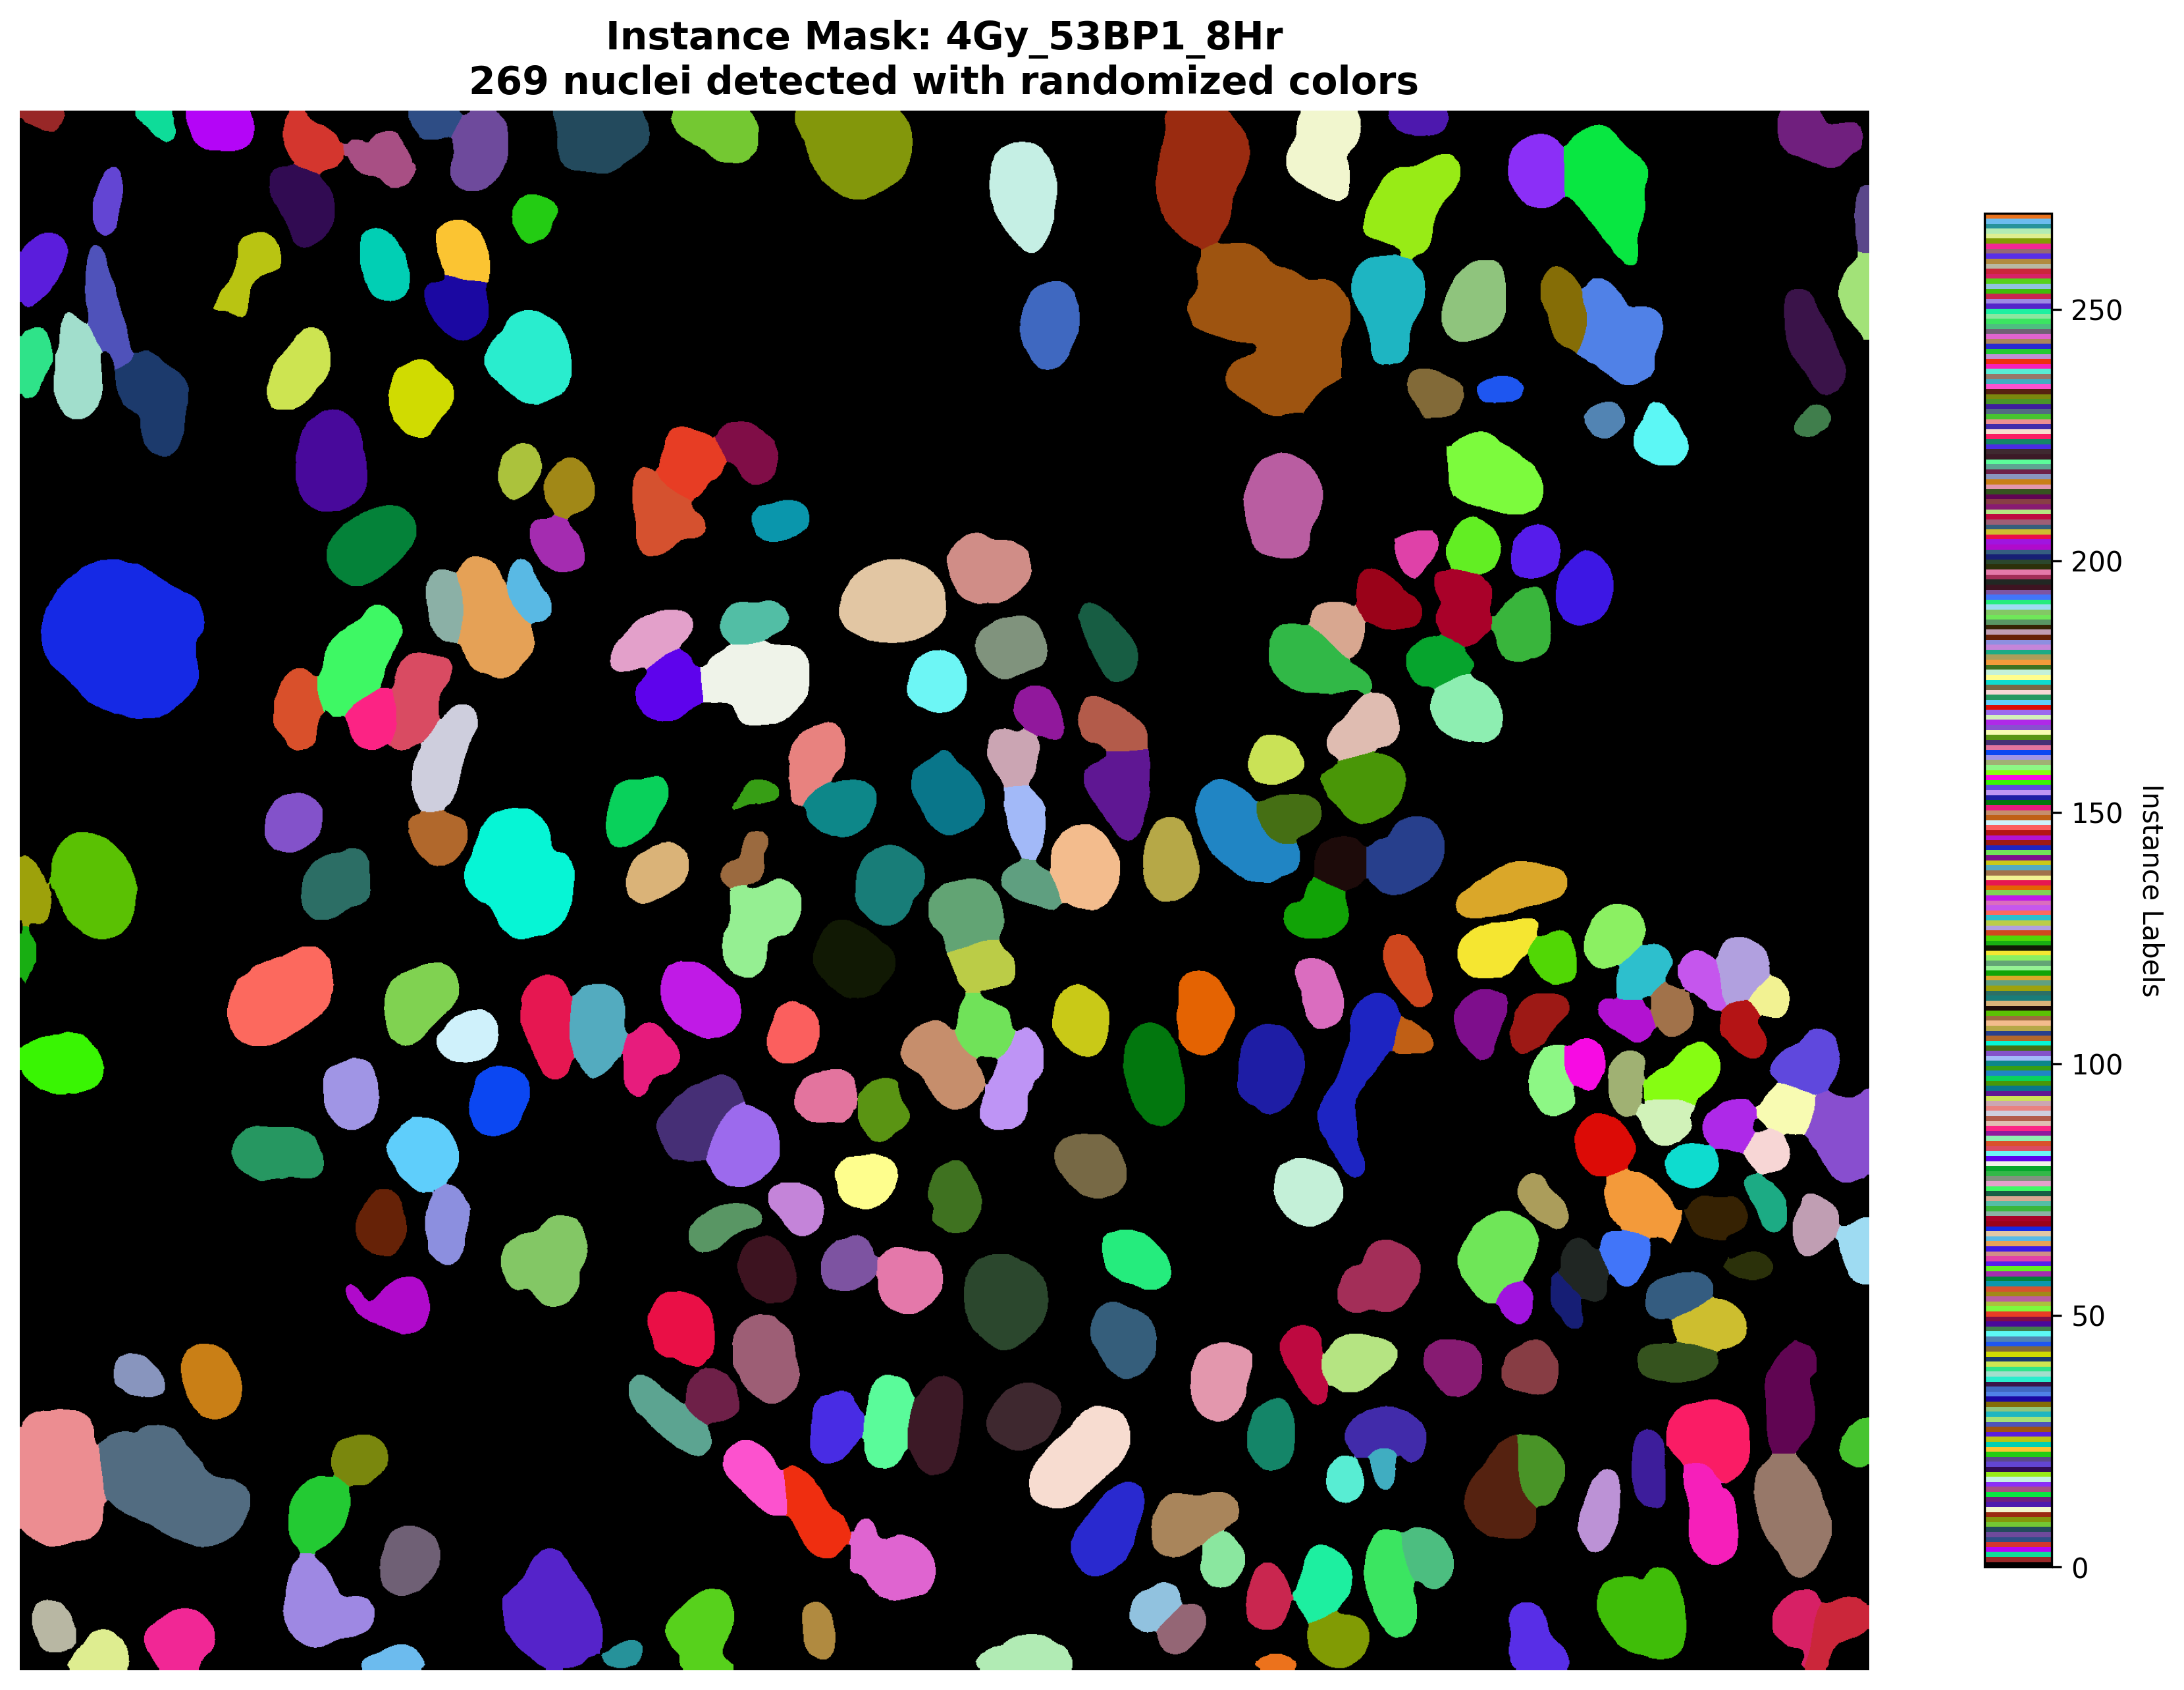

✅ Successfully displayed and saved mask for 4Gy_53BP1_8Hr
💾 Saved as: test/4Gy_53BP1_8Hr_instance_mask_visualization.png

🖼️  Image 2/4: 4Gy_gH2AX_8Hr
--------------------------------------------------
📂 Loaded: 4Gy_gH2AX_8Hr_cp_masks.tif
📐 Mask shape: (2160, 2560)
🔢 Nuclei detected: 245
📊 Value range: 0 - 245


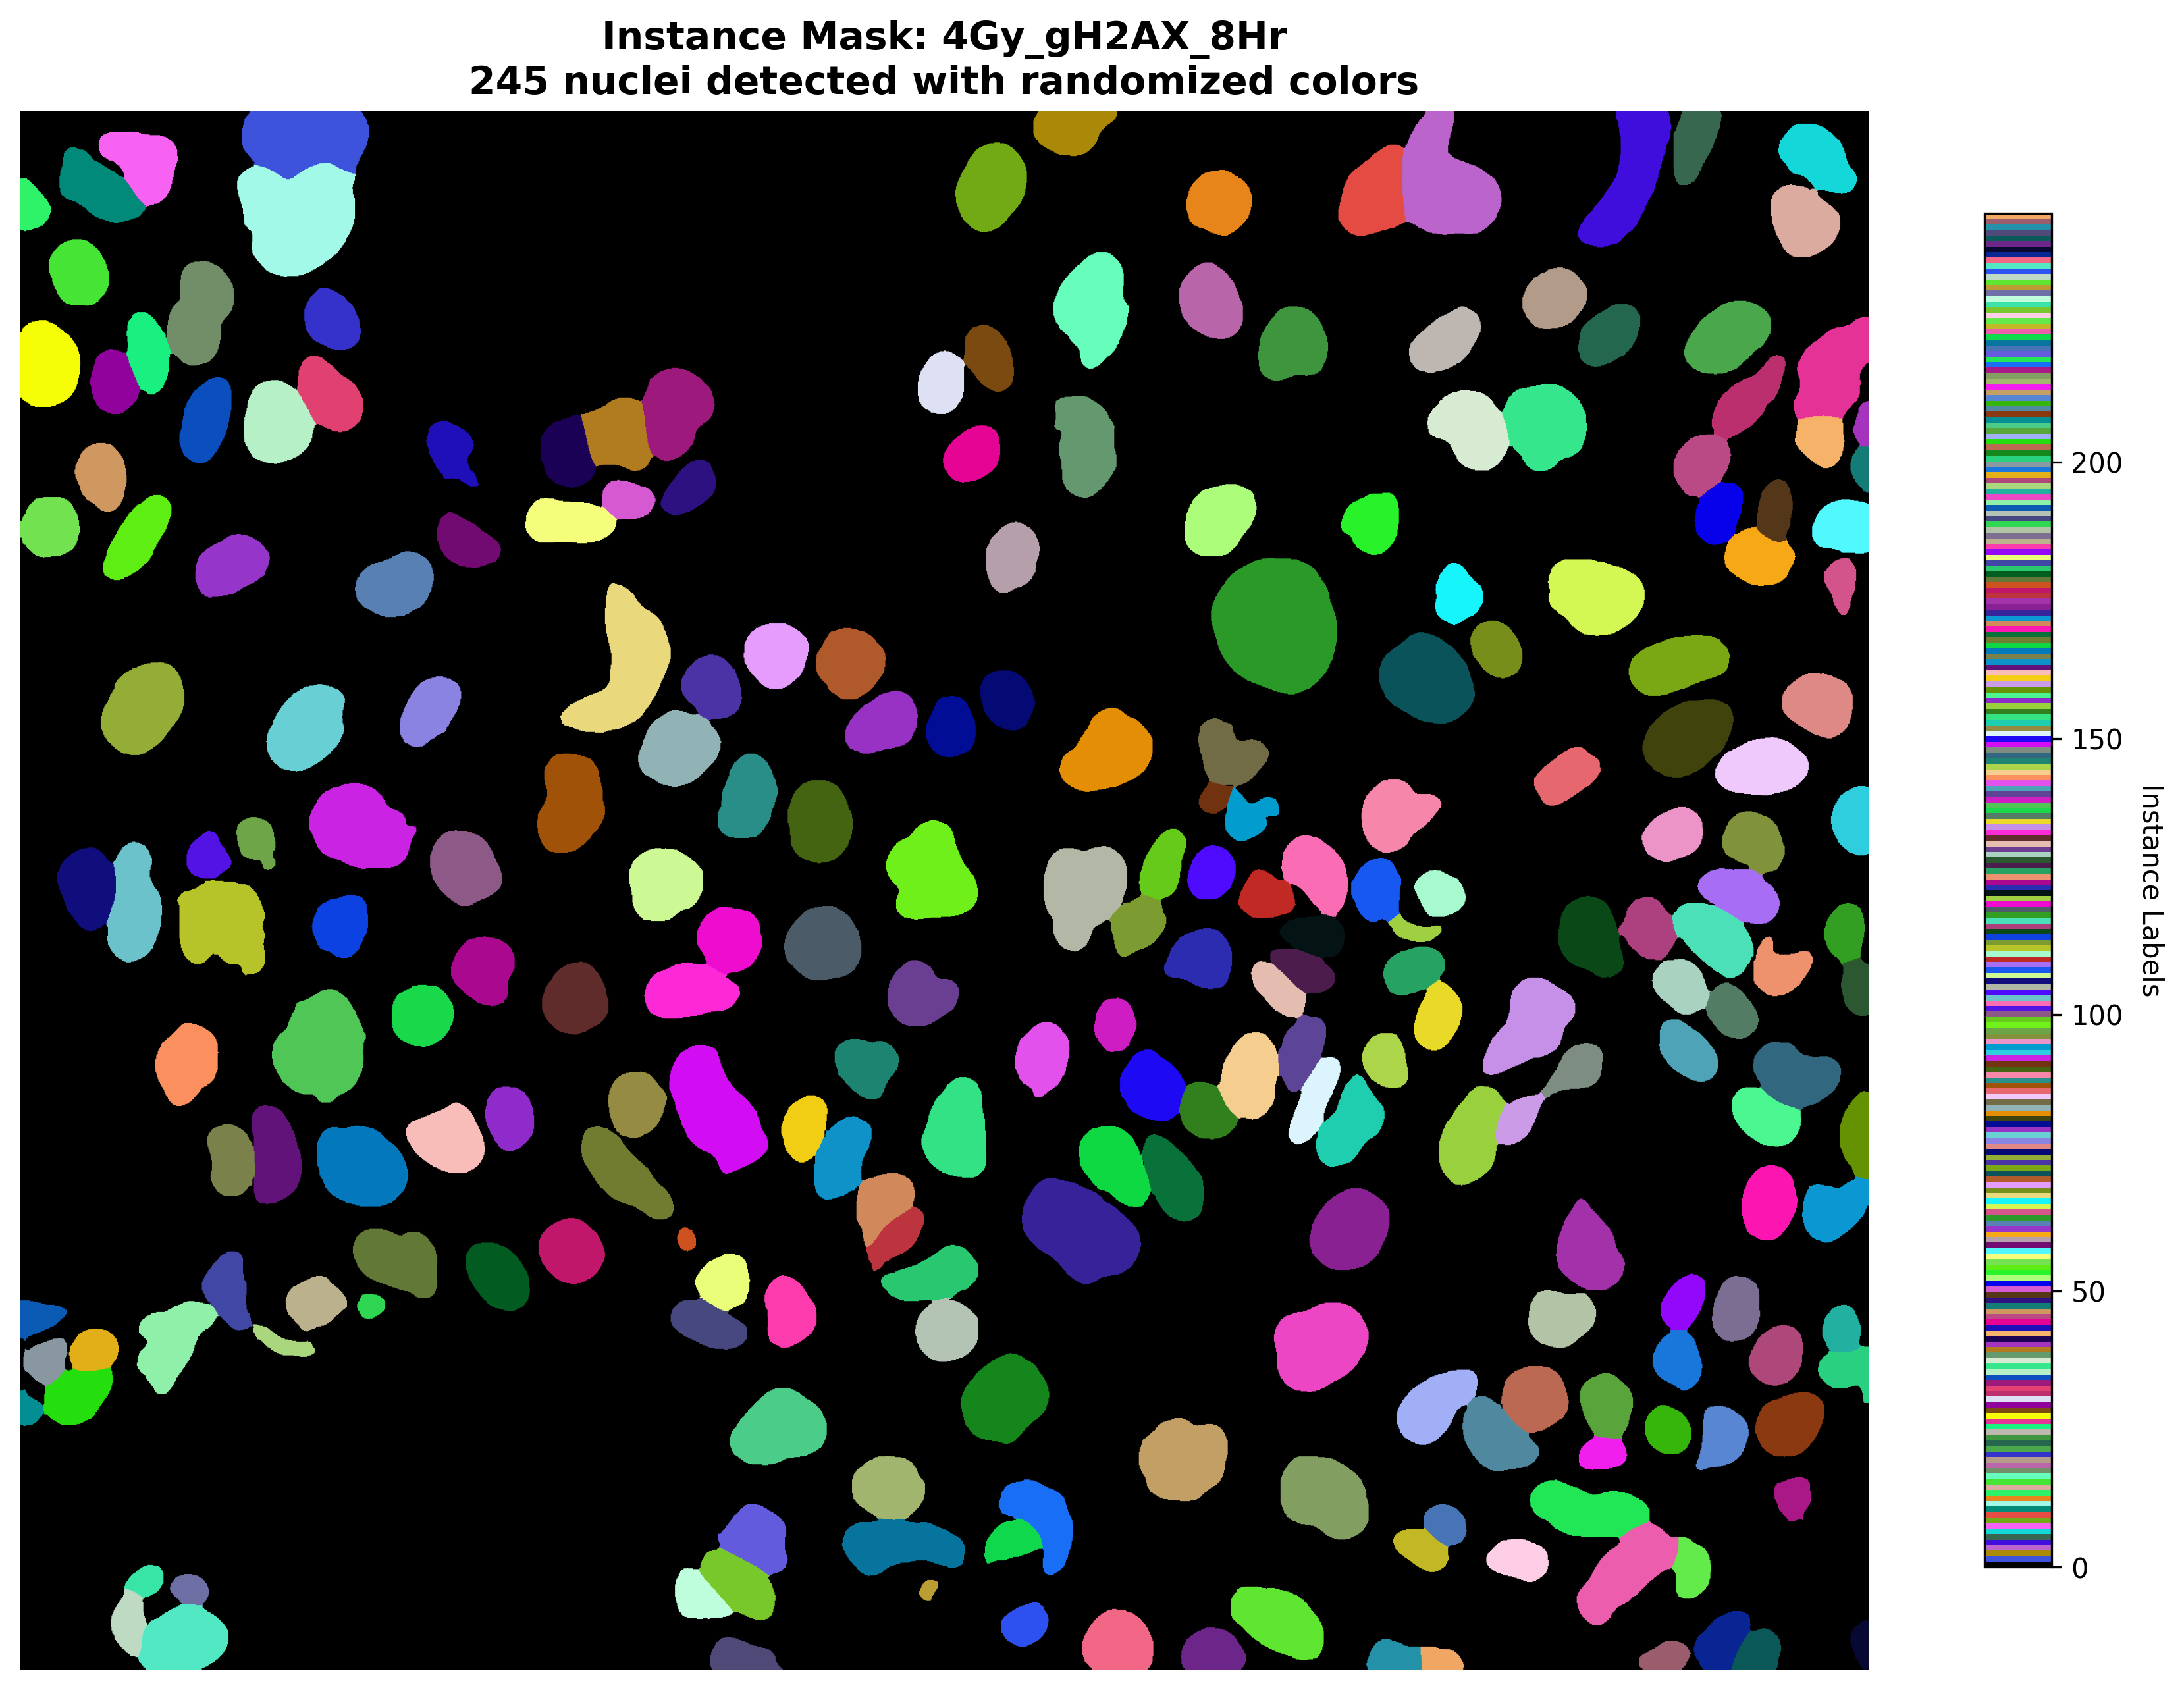

✅ Successfully displayed and saved mask for 4Gy_gH2AX_8Hr
💾 Saved as: test/4Gy_gH2AX_8Hr_instance_mask_visualization.png

🖼️  Image 3/4: 8Gy_53BP1_8Hr
--------------------------------------------------
📂 Loaded: 8Gy_53BP1_8Hr_cp_masks.tif
📐 Mask shape: (2160, 2560)
🔢 Nuclei detected: 80
📊 Value range: 0 - 80


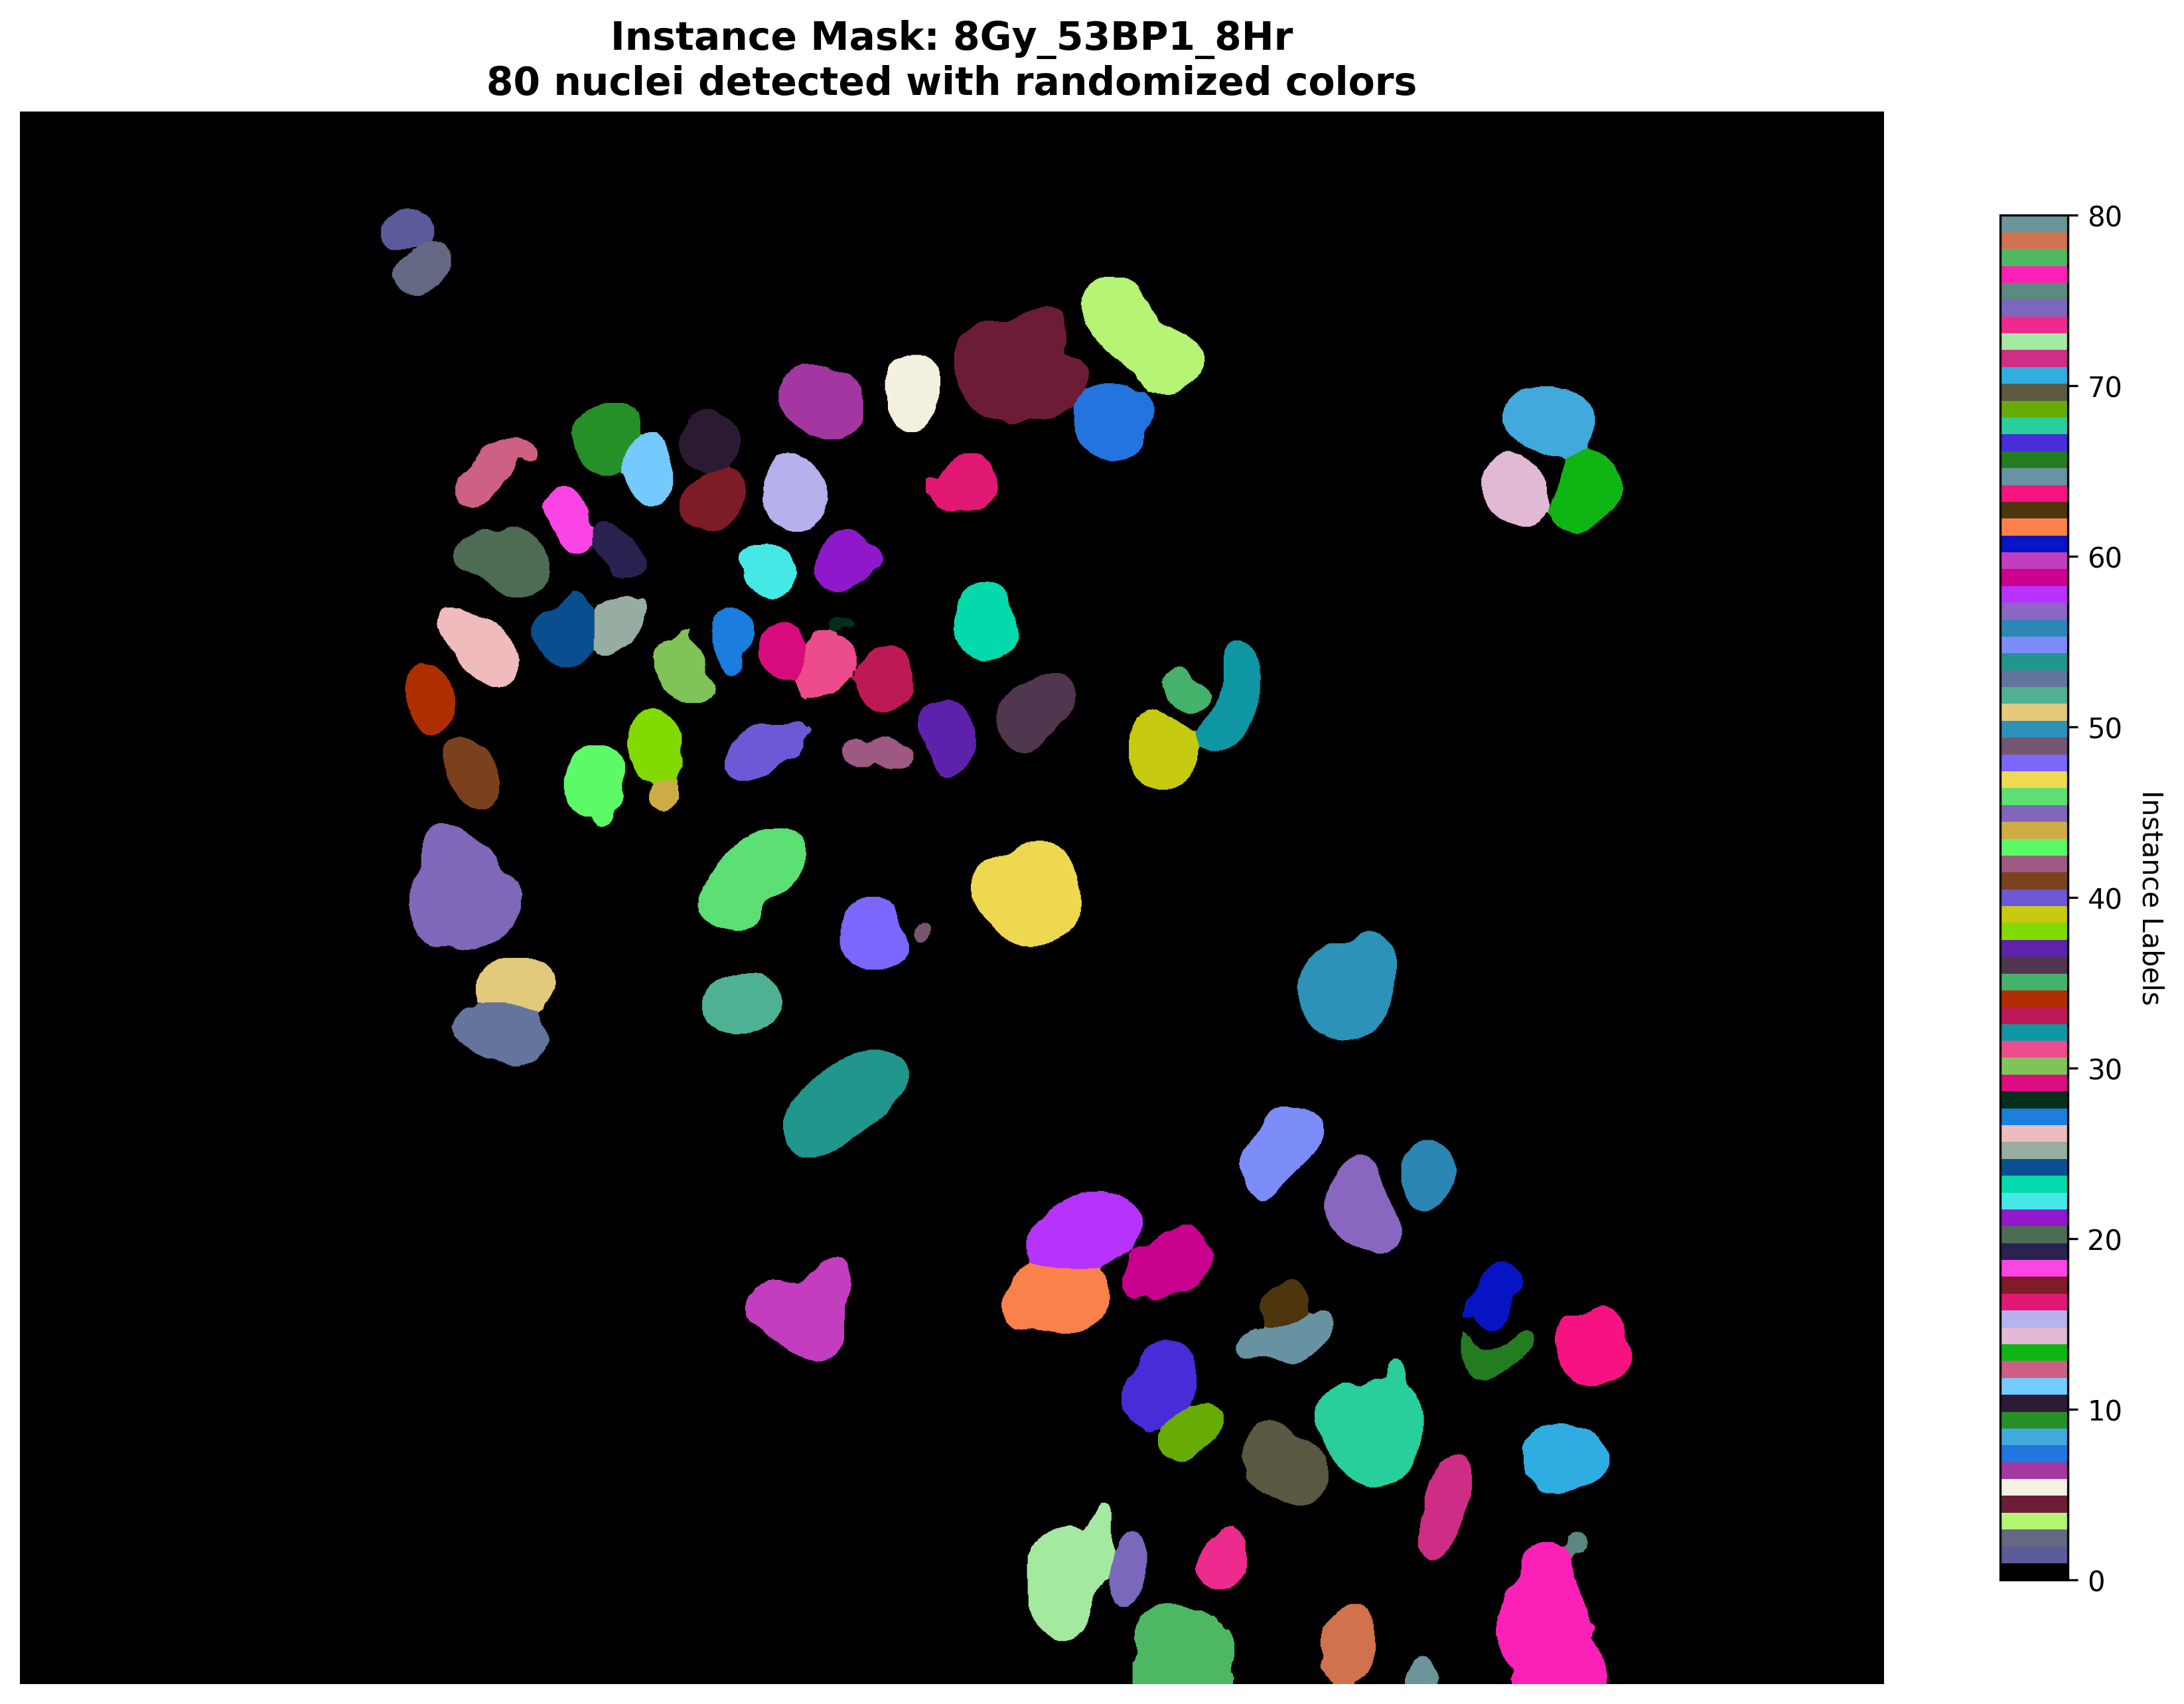

✅ Successfully displayed and saved mask for 8Gy_53BP1_8Hr
💾 Saved as: test/8Gy_53BP1_8Hr_instance_mask_visualization.png

🖼️  Image 4/4: 8Gy_gH2AX_8Hr
--------------------------------------------------
📂 Loaded: 8Gy_gH2AX_8Hr_cp_masks.tif
📐 Mask shape: (2160, 2560)
🔢 Nuclei detected: 104
📊 Value range: 0 - 104


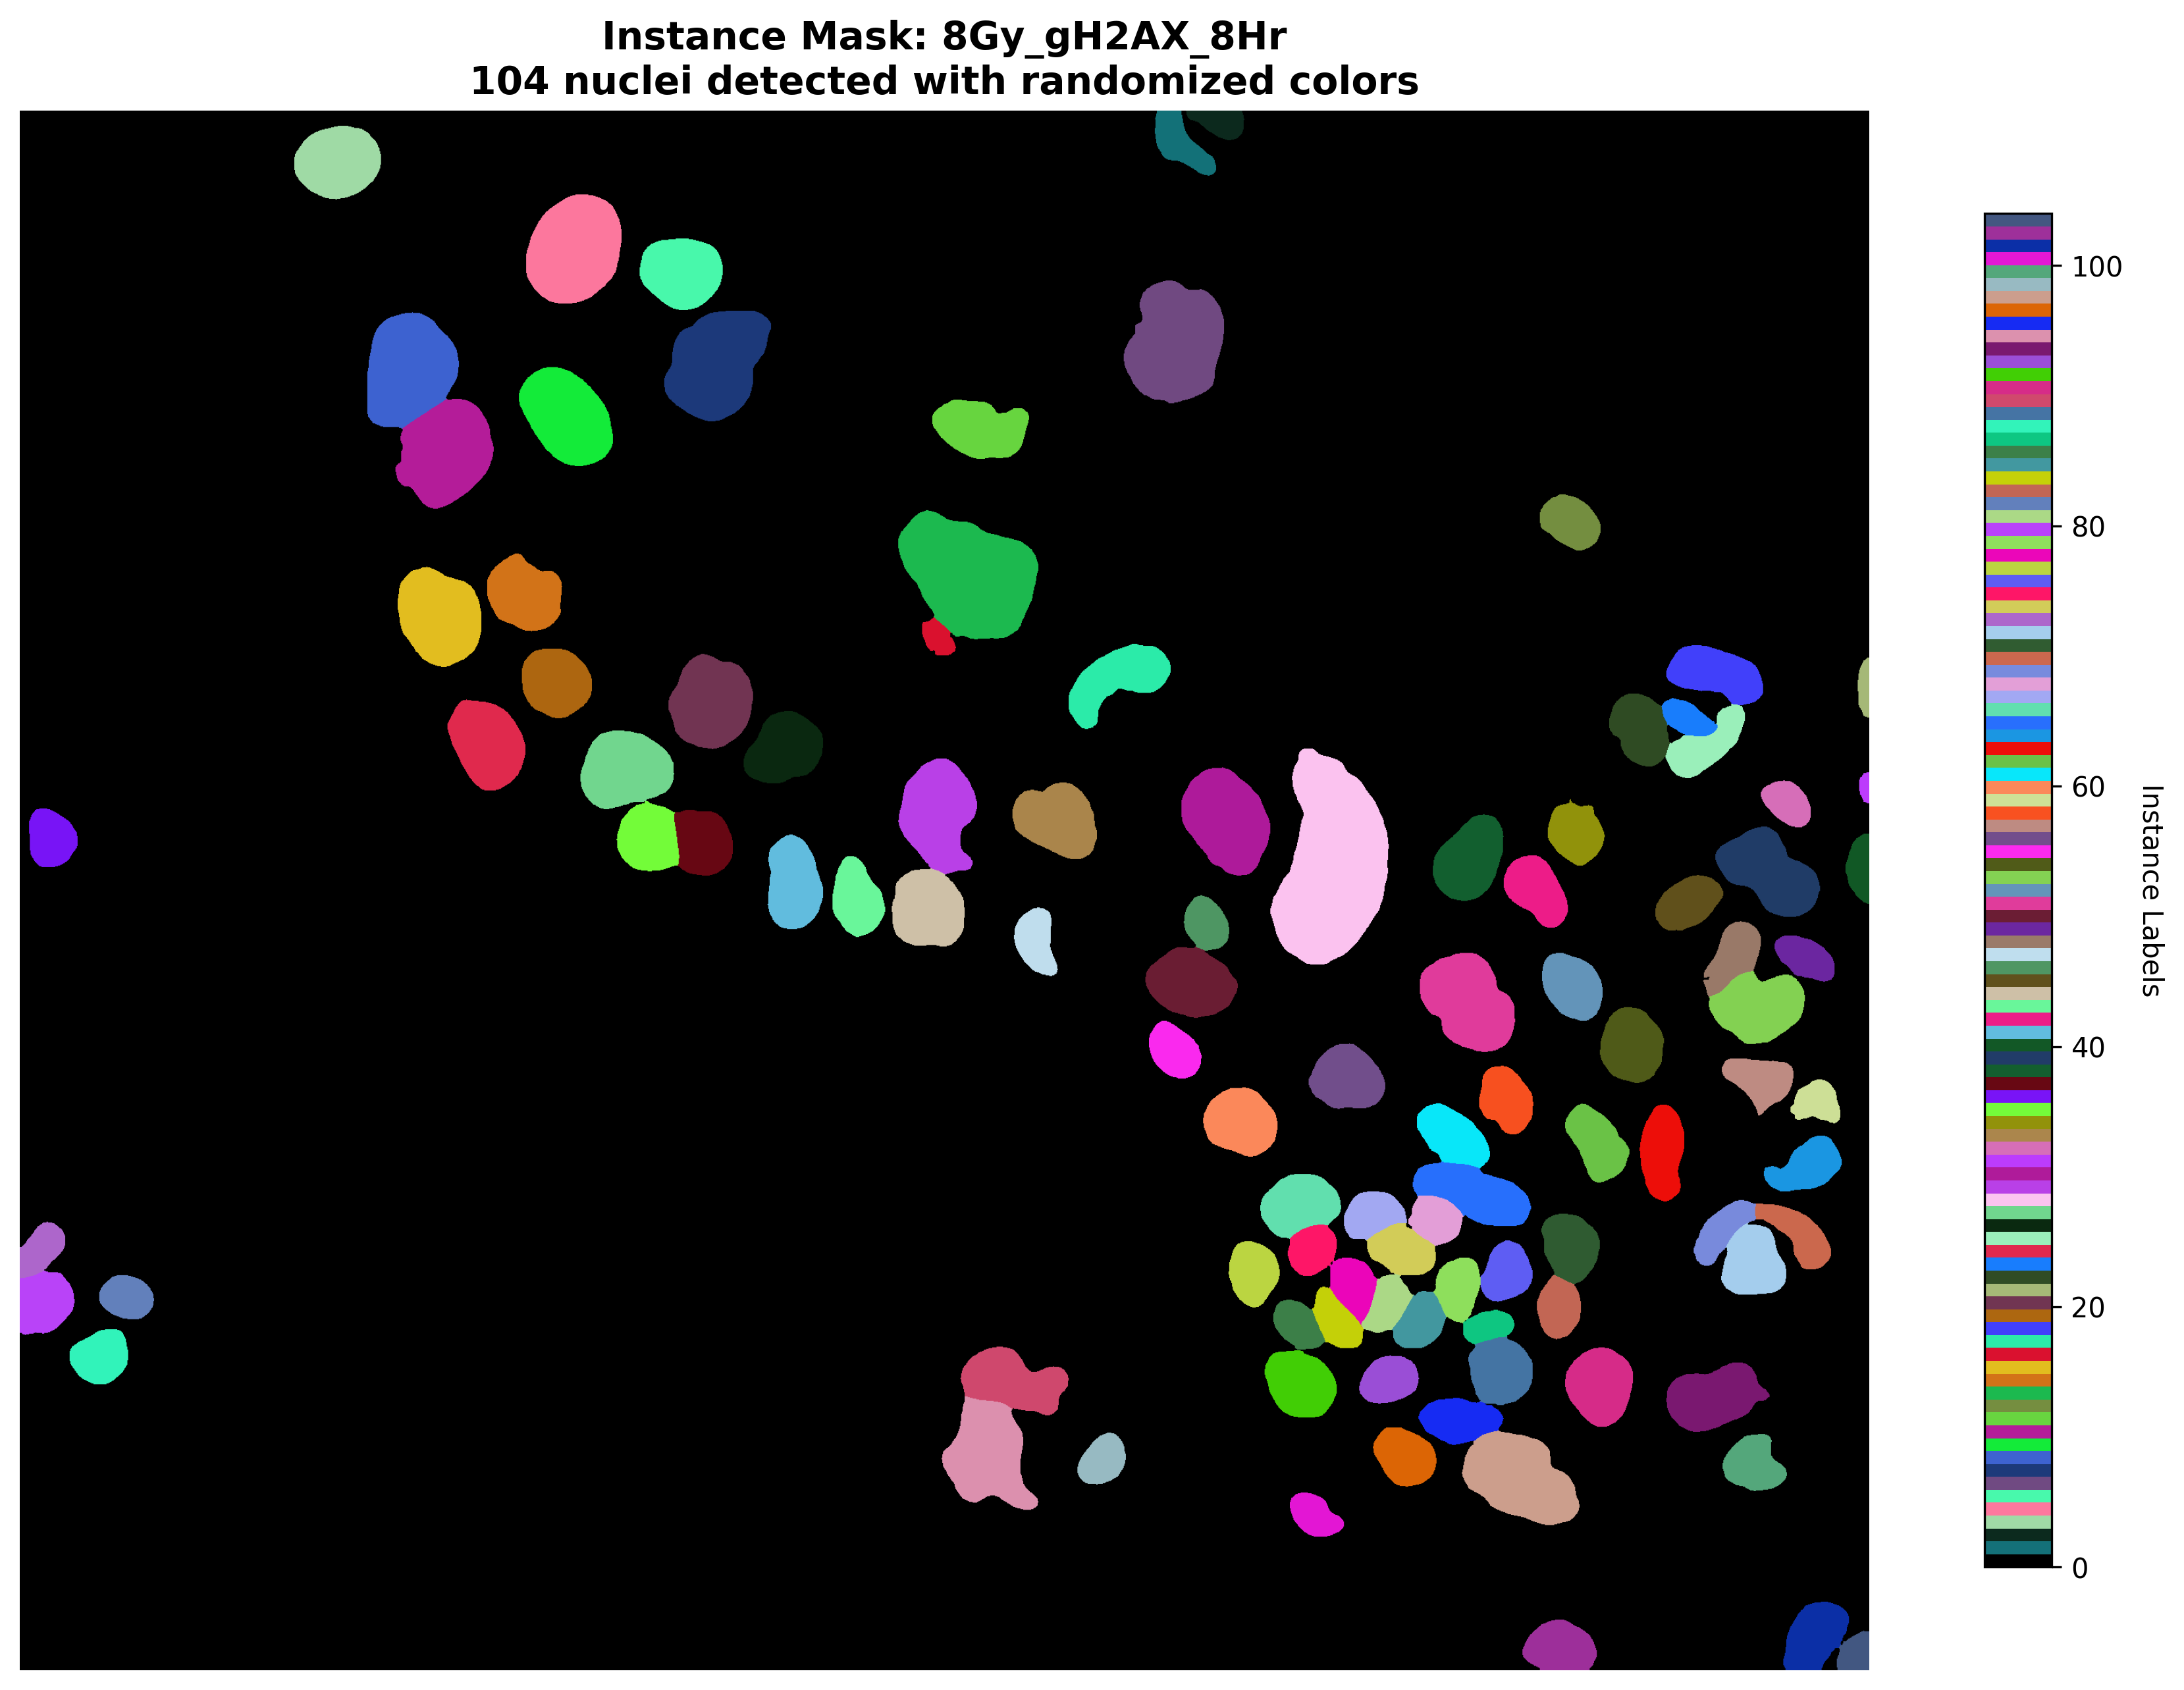

✅ Successfully displayed and saved mask for 8Gy_gH2AX_8Hr
💾 Saved as: test/8Gy_gH2AX_8Hr_instance_mask_visualization.png

🎉 MASK VISUALIZATION AND SAVING COMPLETED!
Total masks processed: 4
Total images saved: 4

📁 SAVED FILES:
  💾 test/4Gy_53BP1_8Hr_instance_mask_visualization.png
  💾 test/4Gy_gH2AX_8Hr_instance_mask_visualization.png
  💾 test/8Gy_53BP1_8Hr_instance_mask_visualization.png
  💾 test/8Gy_gH2AX_8Hr_instance_mask_visualization.png


In [99]:
# Display and Save All Instance Masks from cp_masks.tif files with Randomized Colors
import matplotlib.pyplot as plt
import numpy as np
from cellpose import io
import os
from matplotlib.colors import ListedColormap
from glob import glob
from natsort import natsorted

print("🎨 DISPLAYING AND SAVING ALL INSTANCE MASKS WITH RANDOMIZED COLORS")
print("=" * 70)

# Find all _cp_masks.tif files in test folder
mask_files = natsorted(glob('test/*_cp_masks.tif'))

if len(mask_files) == 0:
    print("❌ No _cp_masks.tif files found in test folder!")
    print("Available files in test folder:")
    all_test_files = [f for f in os.listdir('test') if f.endswith('.tif')]
    for f in all_test_files:
        print(f"  {f}")
else:
    print(f"Found {len(mask_files)} mask files to display and save:")
    for f in mask_files:
        print(f"  📁 {os.path.basename(f)}")
    
    print("\n" + "=" * 70)
    
    # Track saved files
    saved_files = []
    
    # Process each mask file
    for idx, mask_file in enumerate(mask_files):
        img_basename = os.path.splitext(os.path.basename(mask_file))[0].replace('_cp_masks', '')
        
        print(f"\n🖼️  Image {idx+1}/{len(mask_files)}: {img_basename}")
        print("-" * 50)
        
        try:
            # Load the instance mask
            instance_mask = io.imread(mask_file)
            nuclei_count = len(np.unique(instance_mask)) - 1  # Exclude background
            
            print(f"📂 Loaded: {os.path.basename(mask_file)}")
            print(f"📐 Mask shape: {instance_mask.shape}")
            print(f"🔢 Nuclei detected: {nuclei_count}")
            print(f"📊 Value range: {instance_mask.min()} - {instance_mask.max()}")
            
            if nuclei_count == 0:
                print("⚠️  No nuclei detected in this mask")
                continue
            
            # Create randomized colormap for this specific image
            unique_labels = np.unique(instance_mask)
            n_colors = len(unique_labels)
            
            # Generate random colors for each instance (different seed for each image)
            np.random.seed(42 + idx)  # Different seed for each image for variety
            random_colors = np.random.rand(n_colors, 3)  # RGB values between 0-1
            random_colors[0] = [0, 0, 0]  # Keep background black (label 0)
            
            # Create custom colormap
            random_cmap = ListedColormap(random_colors)
            
            # Create figure for display and saving
            plt.figure(figsize=(12, 9), dpi=300)  # High DPI for quality
            
            # Randomized colors for maximum instance distinction
            im = plt.imshow(instance_mask, cmap=random_cmap, vmin=0, vmax=n_colors-1)
            plt.title(f'Instance Mask: {img_basename}\n{nuclei_count} nuclei detected with randomized colors', 
                     fontweight='bold', fontsize=14)
            plt.axis('off')
            
            # Add colorbar
            cbar = plt.colorbar(im, shrink=0.8, aspect=20)
            cbar.set_label('Instance Labels', rotation=270, labelpad=15)
            
            plt.tight_layout()
            
            # Save the figure to test folder
            output_filename = f'test/{img_basename}_instance_mask_visualization.png'
            plt.savefig(output_filename, dpi=300, bbox_inches='tight', 
                       facecolor='white', edgecolor='none')
            saved_files.append(output_filename)
            
            # Display the figure
            plt.show()
            
            print(f"✅ Successfully displayed and saved mask for {img_basename}")
            print(f"💾 Saved as: {output_filename}")
            
        except Exception as e:
            print(f"❌ Error processing {os.path.basename(mask_file)}: {str(e)}")
    
    print("\n" + "=" * 70)
    print("🎉 MASK VISUALIZATION AND SAVING COMPLETED!")
    print(f"Total masks processed: {len(mask_files)}")
    print(f"Total images saved: {len(saved_files)}")
    print("\n📁 SAVED FILES:")
    for saved_file in saved_files:
        print(f"  💾 {saved_file}")
    print("=" * 70)